In [59]:
# https://www.kaggle.com/code/mohamedahmedae/ecgheartbeatcategorization-testset-f1score-99/notebook
import math 
import random
import os
import datetime
from scipy.signal import resample
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LinearRegression, LogisticRegression  
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from scipy import signal
from scipy.signal import medfilt
import pywt
from pywt import wavedec

In [33]:
train_df = pd.read_csv('mitbih_train.csv',header=None)
test_df = pd.read_csv('mitbih_test.csv',header=None)

In [34]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
def check_for_na(data):
    return data.isna().values.sum()

In [37]:
print(f" empty value for train data is :{check_for_na(train_df)}")
print(f" empty value for test data is :{check_for_na(test_df)}")

 empty value for train data is :0
 empty value for test data is :0


In [38]:
# check total data size
data_size = test_df.shape[0] + train_df.shape[0]
print(data_size)

109446


In [39]:
# check number of column
print(test_df.shape[1])

188


In [40]:
train_df.corr()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.778516,0.141264,-0.134788,-0.243921,-0.352727,-0.430698,-0.480058,-0.521888,-0.559848,...,-0.051550,-0.044223,-0.039223,-0.035047,-0.035090,-0.035739,-0.035559,-0.033901,-0.032958,-0.166175
1,0.778516,1.000000,0.501528,-0.024286,-0.148470,-0.164901,-0.234436,-0.285260,-0.322706,-0.341306,...,-0.019324,-0.013356,-0.009154,-0.007511,-0.008674,-0.010175,-0.010693,-0.010116,-0.009987,-0.183442
2,0.141264,0.501528,1.000000,0.672398,0.402170,0.345925,0.281478,0.206464,0.138555,0.077503,...,-0.018531,-0.020627,-0.021478,-0.025592,-0.029119,-0.030466,-0.031462,-0.033109,-0.034741,0.252175
3,-0.134788,-0.024286,0.672398,1.000000,0.819907,0.596827,0.475922,0.389027,0.292549,0.199308,...,-0.017025,-0.024396,-0.028907,-0.036101,-0.041249,-0.042956,-0.043560,-0.045399,-0.046860,0.508486
4,-0.243921,-0.148470,0.402170,0.819907,1.000000,0.881908,0.750680,0.663960,0.563274,0.448298,...,0.020470,0.010719,0.003458,-0.006081,-0.012639,-0.015318,-0.016064,-0.019551,-0.020914,0.508453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,-0.035739,-0.010175,-0.030466,-0.042956,-0.015318,0.005908,0.005361,0.015440,0.023275,0.016165,...,0.738338,0.783177,0.832193,0.895911,0.958530,1.000000,0.953214,0.893247,0.855729,0.037706
184,-0.035559,-0.010693,-0.031462,-0.043560,-0.016064,0.004372,0.003806,0.014076,0.022634,0.015333,...,0.714502,0.753969,0.796068,0.848370,0.903837,0.953214,1.000000,0.948725,0.904684,0.038890
185,-0.033901,-0.010116,-0.033109,-0.045399,-0.019551,0.000171,0.000038,0.010937,0.020454,0.012894,...,0.693137,0.727363,0.764190,0.809050,0.852634,0.893247,0.948725,1.000000,0.965155,0.038924
186,-0.032958,-0.009987,-0.034741,-0.046860,-0.020914,-0.001334,-0.001226,0.010157,0.020295,0.012735,...,0.679757,0.711386,0.744049,0.783552,0.822765,0.855729,0.904684,0.965155,1.000000,0.038146


In [41]:
Classes = {
    0:'N', 
    1:'S', 
    2:'V', 
    3:'F',
    4:'Q'
}

In [42]:
Classes_index = {
    'N': 0, 
    'S': 1, 
    'V': 2, 
    'F': 3, 
    'Q': 4
}

In [43]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB


In [44]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB


In [45]:
feat_cols_name = [i for i in range(train_df.shape[1]-1)]

train_df.columns = feat_cols_name+["label"]
test_df.columns = feat_cols_name+["label"]

In [46]:
train_df["label"] = train_df["label"].astype(int)
test_df["label"] = test_df["label"].astype(int)

In [47]:
train_df["label"] = train_df["label"].map(Classes)
test_df["label"] = test_df["label"].map(Classes)

In [48]:
train_df.columns[train_df.isnull().sum() != 0]
test_df.columns[train_df.isnull().sum() != 0]

Index([], dtype='object')

In [49]:
train_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
count,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,...,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000
mean,0.890360,0.758160,0.423972,0.219104,0.201127,0.210399,0.205808,0.201773,0.198691,0.196757,...,0.005479,0.005025,0.004628,0.004291,0.003945,0.003681,0.003471,0.003221,0.002945,0.002807
std,0.240909,0.221813,0.227305,0.206878,0.177058,0.171909,0.178481,0.177240,0.171778,0.168357,...,0.046693,0.044154,0.042089,0.040525,0.038651,0.037193,0.036255,0.034789,0.032865,0.031924
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.921922,0.682486,0.250969,0.048458,0.082329,0.088416,0.073333,0.066116,0.065000,0.068639,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.991342,0.826013,0.429472,0.166000,0.147878,0.158798,0.145324,0.144424,0.150000,0.148734,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.910506,0.578767,0.341727,0.258993,0.287628,0.298237,0.295391,0.290832,0.283636,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


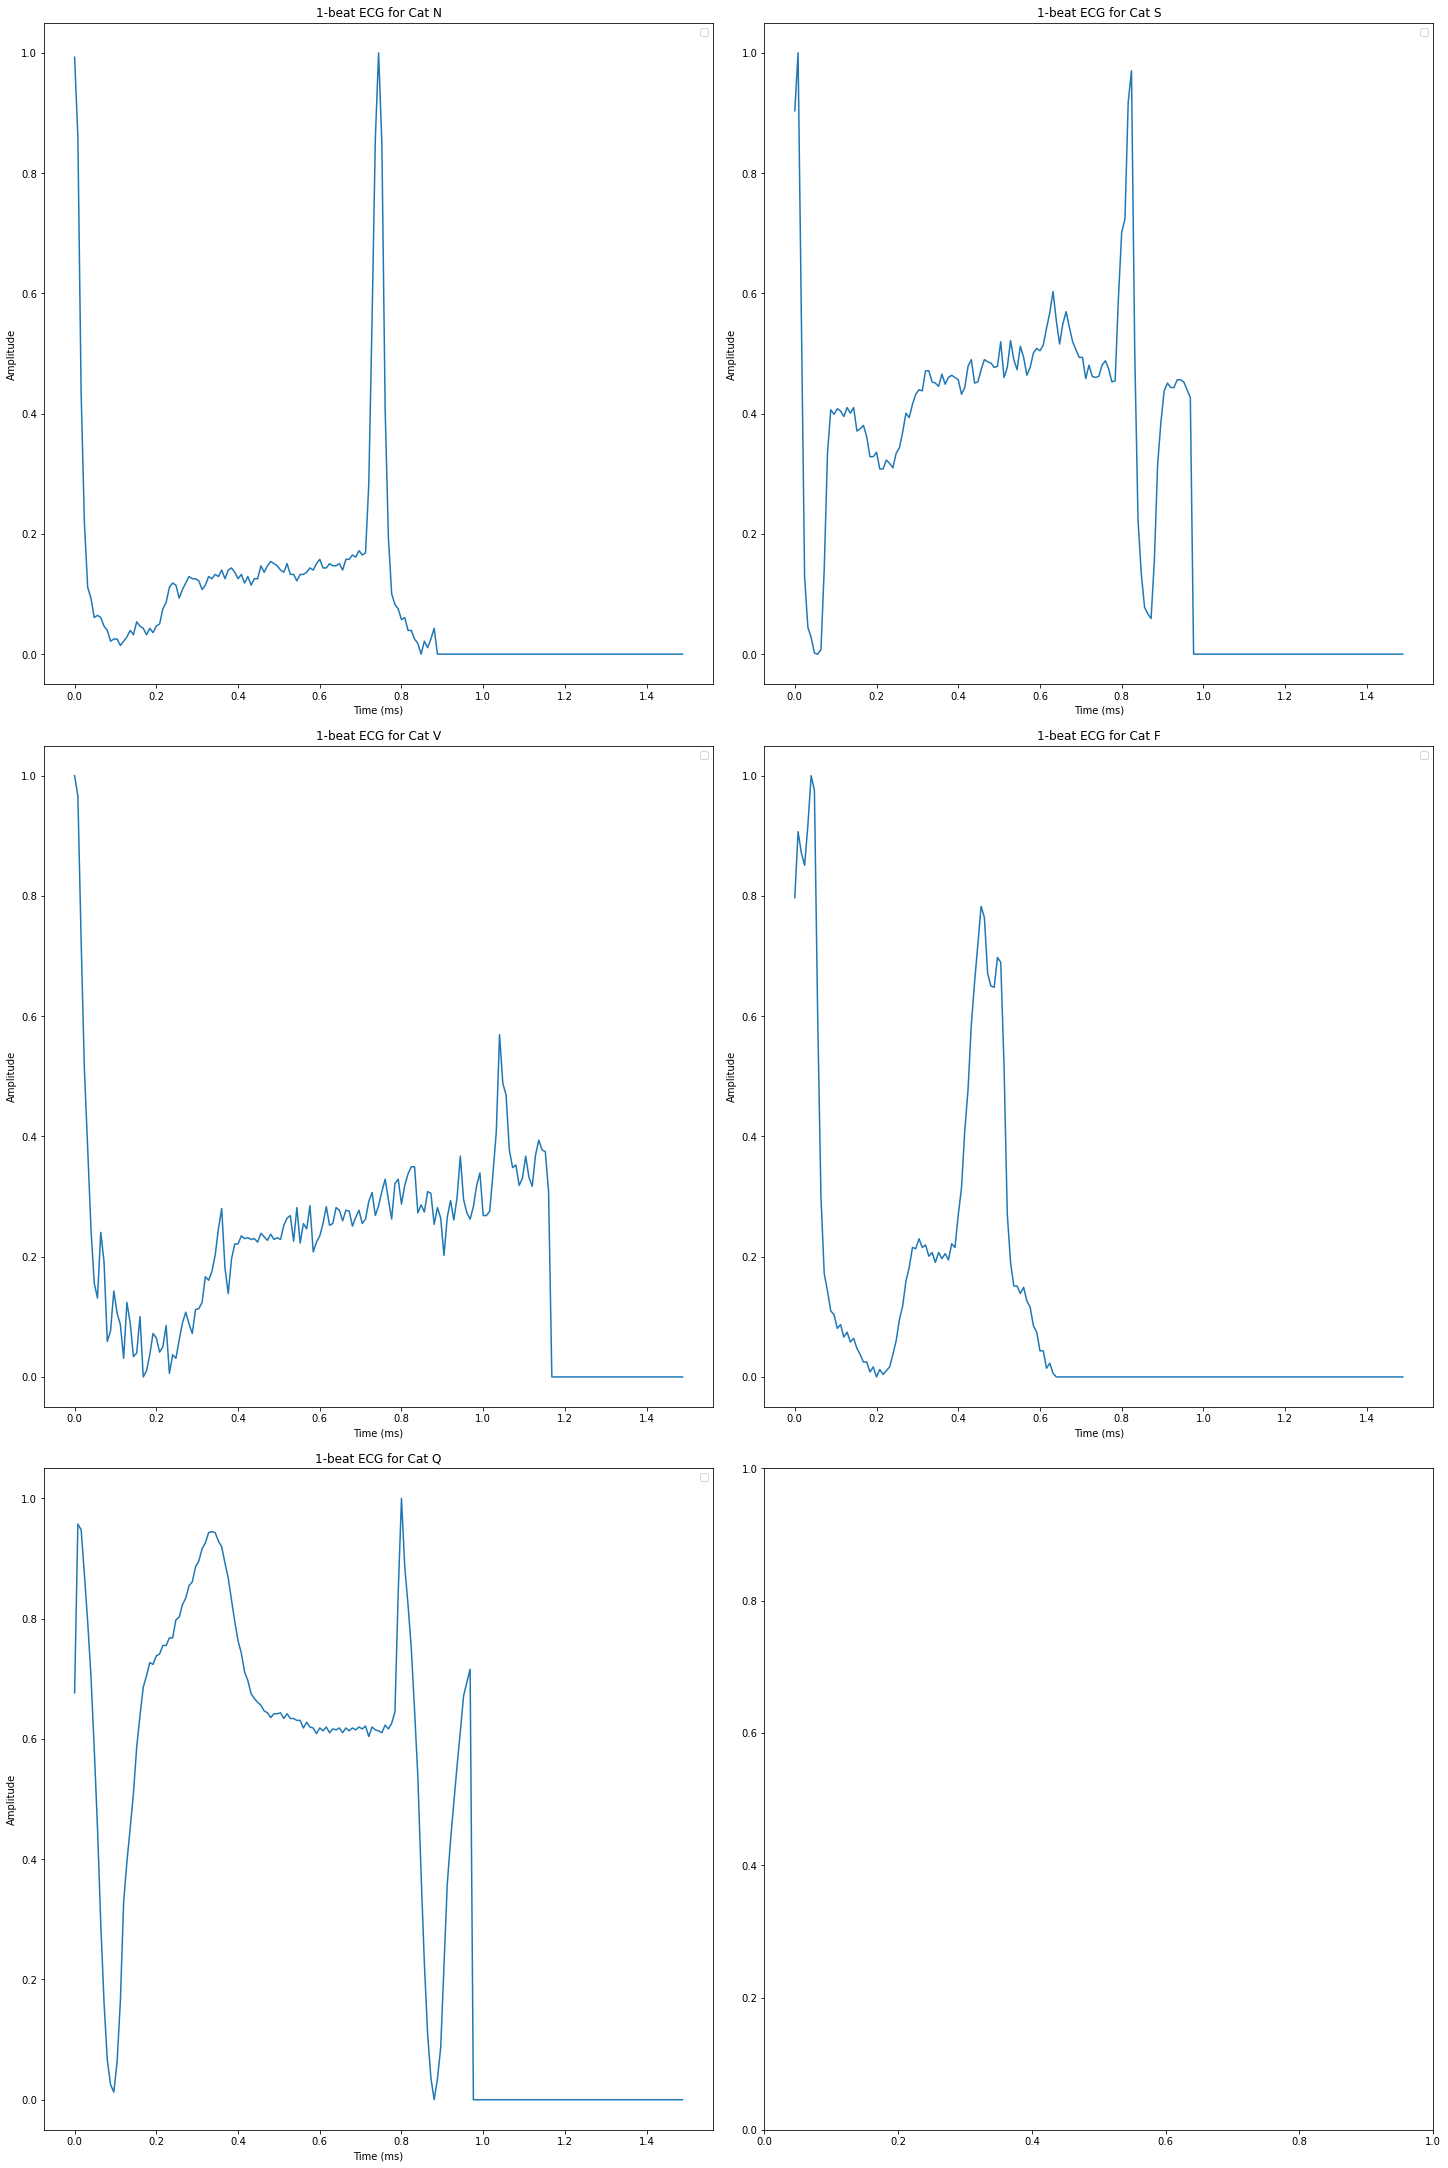

In [50]:
fig, axes= plt.subplots(math.ceil(len(Classes_index.keys())/2), 2, figsize=(20,30), constrained_layout=True)
X = np.arange(0, len(feat_cols_name))*8/1000

i = 0
for key, value in Classes_index.items():
    ax = axes[int(i/2), i%2]
    ax.plot(X, train_df[train_df["label"] == key][feat_cols_name].sample(1).values.reshape(-1,1))
    ax.legend()
    ax.set(title="1-beat ECG for Cat {}".format(key))
    ax.set(ylabel="Amplitude")
    ax.set(xlabel="Time (ms)")
    i+=1

In [51]:
def stretch(x):
    l = int(len(feat_cols_name) * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < len(feat_cols_name):
        y_ = np.zeros(shape=(len(feat_cols_name), ))
        y_[:l] = y
    else:
        y_ = y[:len(feat_cols_name)]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

def gaussian_noise(signal):
    noise=np.random.normal(0,0.01, len(feat_cols_name))
    return (signal+noise)

def augment(x):
    result = np.zeros(shape= (4, len(feat_cols_name)))
    for i in range(3):
        if random.random() < 0.25:
            new_X = gaussian_noise(x)
        elif random.random() < 0.50:
            new_X = stretch(x)           
        elif random.random() < 0.75:
            new_X = amplify(x)
        else:
            new_X = gaussian_noise(x)
            new_X = stretch(new_X)
            new_X = amplify(new_X)
        result[i, :] = new_X
    return result

In [52]:
X_train = train_df[feat_cols_name].values
y_train = train_df["label"].values

X_test = test_df[feat_cols_name].values
y_test = test_df["label"].values

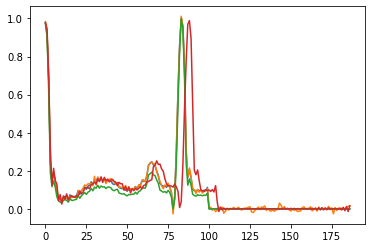

In [53]:
plt.plot(X_train[0])
plt.plot(gaussian_noise(X_train[0]))
plt.plot(amplify(X_train[0]))
plt.plot(stretch(X_train[0]))
plt.show()

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2, stratify=y_train)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((78798, 187), (78798,), (8756, 187), (8756,))

In [29]:
# tmp_X_train = X_train.copy()
# tmp_y_train = y_train.copy()

# X_train = []
# y_train = []
# for i in range(0, len(tmp_y_train)):
#     augment_X = augment(tmp_X_train[i])
#     augment_y = np.ones(shape=(augment_X.shape[0],), dtype=int)*tmp_y_train[i]

#     X_train.extend(augment_X)
#     y_train.extend(augment_y)
    
# X_train = np.array(X_train)
# y_train = np.array(y_train)

In [55]:
X_train.shape, y_train.shape

((78798, 187), (78798,))

In [57]:
# X_train = X_train.reshape((-1, len(feat_cols_name), 1))
# X_val = X_val.reshape((-1, len(feat_cols_name), 1))
# X_test = X_test.reshape((-1, len(feat_cols_name), 1))

# y_train = y_train.reshape((-1, 1))
# y_val = y_val.reshape((-1, 1))
# y_test = y_test.reshape((-1, 1))
svm_class = SVC(kernel='linear')
svm_class.fit(X_train, y_train)
svm_pred = svm_class.predict(X_val)

print(svm_pred)
accuracy_score(y_val, svm_pred)

['N' 'N' 'N' ... 'N' 'N' 'N']


0.9199406121516674

In [58]:
forest = RandomForestClassifier(n_estimators=10, criterion="entropy", random_state=0)
forest.fit(X_train, y_train)
forest.score(X_train, y_train)
forest_pred = forest.predict(X_val)
accuracy_score(y_val, forest_pred)

0.9753312014618547

In [61]:
log_reg= LogisticRegression(random_state=0)  
log_reg.fit(X_train, y_train) 
log_reg.score(X_train, y_train)
log_reg_pred = log_reg.predict(X_val)
accuracy_score(y_val, log_reg_pred)

C:\Users\WRASHTECH\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9753312014618547

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, classification_report, precision_score, recall_score
from sklearn.metrics import f1_score as f1_score_rep
import seaborn as sn


def print_score(y_pred, y_real, label_encoder):
    print("Accuracy: ", accuracy_score(y_real, y_pred))
    print("Precision:: ", precision_score(y_real, y_pred, average="micro"))
    print("Recall:: ", recall_score(y_real, y_pred, average="micro"))
    print("F1_Score:: ", f1_score_rep(y_real, y_pred, average="micro"))

    print()
    print("Macro precision_recall_fscore_support (macro) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="macro"))

    print()
    print("Macro precision_recall_fscore_support (micro) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="micro"))

    print()
    print("Macro precision_recall_fscore_support (weighted) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="weighted"))
    
    print()
    print("Confusion Matrix")
    cm = confusion_matrix(y_real, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index = [i for i in label_encoder],
                  columns = [i for i in label_encoder])
    plt.figure(figsize = (10,10))
    sn.heatmap(df_cm, annot=True)

    print()
    print("Classification Report")
    print(classification_report(y_real, y_pred, target_names=label_encoder))